# Nightshade penalty method validation and Analysis

## Imports

In [1]:
# Package imports
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from IPython.display import display
import time
import pandas as pd
import seaborn as sns
import clip

# Our custom implementations
from nightshade import Nightshade
from perturbation_methods import fgsm_penalty, pgd_penalty, nightshade_penalty

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Configuration

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target_concept = 'cat'
epsilon = 0.05
test_image_path = 'test_images/dog.jpg'


## Initialize Nightshade

In [3]:
methods = {
    #'fgsm': fgsm_penalty,
    #'pgd': pgd_penalty,
    'nightshade': nightshade_penalty
}

nightshade_instances = {
    name: Nightshade(
        penalty_method=method,
        target_concept=target_concept,
        eps=epsilon,
        device=device
    ) for name, method in methods.items()
}

/home/zabibeau/miniforge3/envs/ml/lib/python3.11/site-packages/diffusers/pipelines/pipeline_loading_utils.py:285: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-1 via `revision='fp16'`. This behavior is deprecated and will be removed in diffusers v1. One should use `variant='fp16'` instead. However, it appears that stabilityai/stable-diffusion-2-1 currently does not have the required variant filenames in the 'main' branch. 
 The Diffusers team and community would be very grateful if you could open an issue: https://github.com/huggingface/diffusers/issues/new with the title 'stabilityai/stable-diffusion-2-1 is missing fp16 files' so that the correct variant file can be added.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/zabibeau/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/zabibeau/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /home/zabibeau/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/zabibeau/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/home/zabibeau/miniforge3/envs/ml/lib/python3.

In [4]:
def load_and_prepare_image(path, size=512):
    img = Image.open(path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    return transform(img).unsqueeze(0).to(device)

original_img = load_and_prepare_image(test_image_path)

def visualize_results(original, perturbed, method_name):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    orig_img = original.squeeze().cpu().numpy().transpose(1, 2, 0)
    orig_img = (orig_img * 0.5 + 0.5).clip(0, 1)
    ax1.imshow(orig_img)
    ax1.set_title("Original Image")
    ax1.axis('off')
    
    # Perturbed image
    pert_img = perturbed.squeeze().cpu().numpy().transpose(1, 2, 0)
    pert_img = (pert_img * 0.5 + 0.5).clip(0, 1)
    ax2.imshow(pert_img)
    ax2.set_title(f"{method_name} Perturbed")
    ax2.axis('off')
    
    # Difference (magnified)
    diff = np.abs(pert_img - orig_img) * 10  # Amplify differences
    ax3.imshow(diff.clip(0, 1))
    ax3.set_title("Difference (10x)")
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()

## Validation Test 1: Basic Functionality

Testing nightshade method...


  0%|          | 0/50 [00:00<?, ?it/s]

Completed in 14.53 seconds


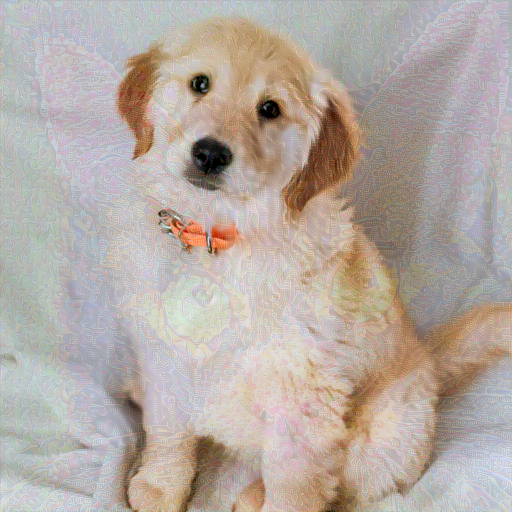

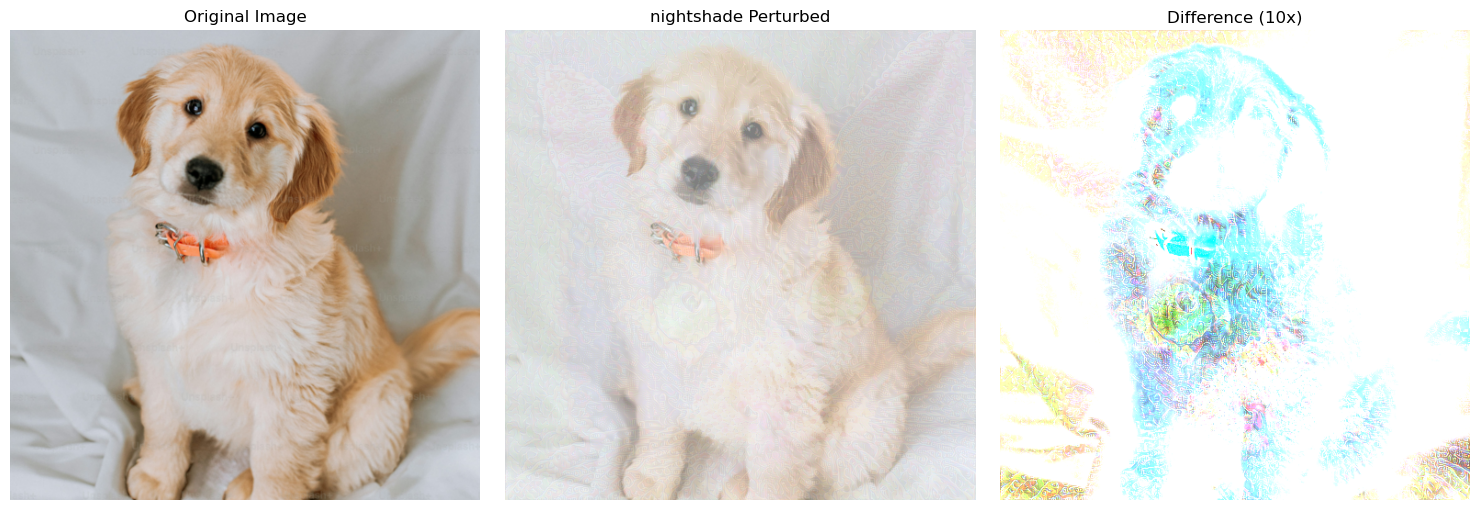

In [5]:
print("## Validation Test 1: Basic Functionality")

test_img = Image.open(test_image_path).convert("RGB")

for name, instance in nightshade_instances.items():
    print(f"\nTesting {name} method...")
    start_time = time.time()
    perturbed_img = instance.generate(test_img, target_concept=target_concept)
    elapsed = time.time() - start_time
    
    print(f"Completed in {elapsed:.2f} seconds")
    display(perturbed_img)
    
    # Convert back to tensor for visualization
    perturbed_tensor = transforms.ToTensor()(perturbed_img).unsqueeze(0).to(device)
    visualize_results(original_img, perturbed_tensor, name)

In [6]:
print("## Validation Test 2: Latent Space Manipulation")

def compare_latents(original, perturbed, nightshade_instance):
    # Convert inputs to matching precision (half precision for SD pipeline)
    with torch.no_grad():
        orig_latent = nightshade_instance.get_latent(original.half())
        pert_latent = nightshade_instance.get_latent(perturbed.half())
    
    # Convert latents to float32 for stable comparison
    orig_latent = orig_latent.float()
    pert_latent = pert_latent.float()
    
    distance = torch.norm(orig_latent - pert_latent).item()
    cosine_sim = torch.nn.functional.cosine_similarity(
        orig_latent.flatten(), 
        pert_latent.flatten(), 
        dim=0
    ).item()
    
    return distance, cosine_sim

# Prepare consistent transform pipeline
transform_pipeline = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Prepare original image tensor
original_img = transform_pipeline(test_img).unsqueeze(0).to(device)

results = []
for name, instance in nightshade_instances.items():
    print(f"Processing {name}...")
    perturbed_img = instance.generate(test_img, target_concept=target_concept)
    
    # Convert perturbed image using same transform pipeline
    perturbed_tensor = transform_pipeline(perturbed_img).unsqueeze(0).to(device)
    
    dist, sim = compare_latents(original_img, perturbed_tensor, instance)
    results.append({
        "Method": name,
        "Latent Distance": dist,
        "Cosine Similarity": sim
    })

results_df = pd.DataFrame(results)
print("\nLatent Space Comparison:")
display(results_df)

## Validation Test 2: Latent Space Manipulation
Processing nightshade...


  0%|          | 0/50 [00:00<?, ?it/s]


Latent Space Comparison:


,Method,Latent Distance,Cosine Similarity
0,nightshade,534.070496,0.45768


In [8]:
print("## Validation Test 3: Effectiveness Against Model")

def test_model_misclassification(original, perturbed, target_concept):
    # Load CLIP model for evaluation
    model, preprocess = clip.load("ViT-B/32", device=device)

    # Convert tensors to PIL Images if needed
    if isinstance(original, torch.Tensor):
        original = transforms.ToPILImage()(original.squeeze().cpu())
    if isinstance(perturbed, torch.Tensor):
        perturbed = transforms.ToPILImage()(perturbed.squeeze().cpu())
    
    # Preprocess images
    orig_preprocessed = preprocess(original).unsqueeze(0).to(device)
    pert_preprocessed = preprocess(perturbed).unsqueeze(0).to(device)
    
    # Text prompts
    text_inputs = clip.tokenize([
        f"a photo of a {target_concept}"
    ]).to(device)
    
    # Calculate features
    with torch.no_grad():
        orig_features = model.encode_image(orig_preprocessed)
        pert_features = model.encode_image(pert_preprocessed)
        text_features = model.encode_text(text_inputs)
    
    # Calculate similarities
    orig_similarities = (orig_features @ text_features.T).softmax(dim=-1)
    pert_similarities = (pert_features @ text_features.T).softmax(dim=-1)
    
    return {
        "Original Confidence": orig_similarities[0][0].item(),
        "Perturbed Confidence": pert_similarities[0][0].item(),
        "Confidence Increase": pert_similarities[0][0].item() - orig_similarities[0][0].item()
    }

# Run evaluation
evaluation_results = []
for name, instance in nightshade_instances.items():
    perturbed_img = instance.generate(test_img, target_concept=target_concept)
    perturbed_tensor = transforms.ToTensor()(perturbed_img).unsqueeze(0).to(device)
    
    metrics = test_model_misclassification(
        original_img, 
        perturbed_tensor, 
        target_concept
    )
    metrics["Method"] = name
    evaluation_results.append(metrics)

evaluation_df = pd.DataFrame(evaluation_results)
print("\nMisclassification Effectiveness:")
display(evaluation_df)

## Validation Test 3: Effectiveness Against Model


  0%|          | 0/50 [00:00<?, ?it/s]


Misclassification Effectiveness:


,Original Confidence,Perturbed Confidence,Confidence Increase,Method
0,1.0,1.0,0.0,nightshade
